In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
found = False
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            path = os.path.join(dirname, filename)
            df = pd.read_csv(path)
            found = True
            break
if not found:
    df = pd.read_csv('data/default_of_credit_card_clients.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={'default.payment.next.month': 'target', 'default_payment_next_month': 'target'}, inplace=True)

if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

print(df.shape)

(30000, 24)


In [3]:
df['avg_limit_use'] = (
    (df['bill_amt1'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt2'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt3'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt4'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt5'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt6'] / df['limit_bal'].replace(0, 1))
) / 6

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['total_delay_score'] = df[pay_cols].apply(lambda x: x[x > 0].sum(), axis=1)
df['max_delay_month'] = df[pay_cols].max(axis=1)
df['zero_payment_count'] = (df[pay_cols] == -2).sum(axis=1)

df['bill_trend'] = df['bill_amt1'] - df['bill_amt6']

for i in range(1, 7):
    df[f'unpaid_balance_{i}'] = df[f'bill_amt{i}'] - df[f'pay_amt{i}']

df['avg_unpaid_balance'] = df[[f'unpaid_balance_{i}' for i in range(1, 7)]].mean(axis=1)
df.drop([f'unpaid_balance_{i}' for i in range(1, 7)], axis=1, inplace=True)

for i in range(1, 7):
    bill_col = f'bill_amt{i}'
    pay_col = f'pay_amt{i}'
    df[f'pay_ratio_{i}'] = np.where(df[bill_col] <= 0, 1, df[pay_col] / df[bill_col])

df['avg_pay_ratio'] = df[[f'pay_ratio_{i}' for i in range(1, 7)]].mean(axis=1)
df.drop([f'pay_ratio_{i}' for i in range(1, 7)], axis=1, inplace=True)

df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

print(df.shape)

(30000, 31)


In [4]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio, 
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [100, 200, 300, 500],       
    'learning_rate': [0.01, 0.03, 0.05, 0.1],   
    'max_depth': [3, 4, 5, 6, 8],              
    'min_child_weight': [1, 3, 5],              
    'gamma': [0, 0.1, 0.2, 0.5],                
    'subsample': [0.7, 0.8, 0.9],            
    'colsample_bytree': [0.6, 0.7, 0.8],     
    'reg_alpha': [0, 0.01, 0.1, 1],             
    'reg_lambda': [1, 1.5, 2]                   
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  
    scoring='roc_auc',     
    cv=5,       
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [5]:
random_search.fit(X_train, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
0.7885764759637222


In [6]:
best_model = random_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
best_threshold = thresholds[optimal_idx]

print(best_threshold)

0.54540837


              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4673
           1       0.51      0.60      0.55      1327

    accuracy                           0.78      6000
   macro avg       0.70      0.72      0.70      6000
weighted avg       0.80      0.78      0.79      6000

0.7821481966582869


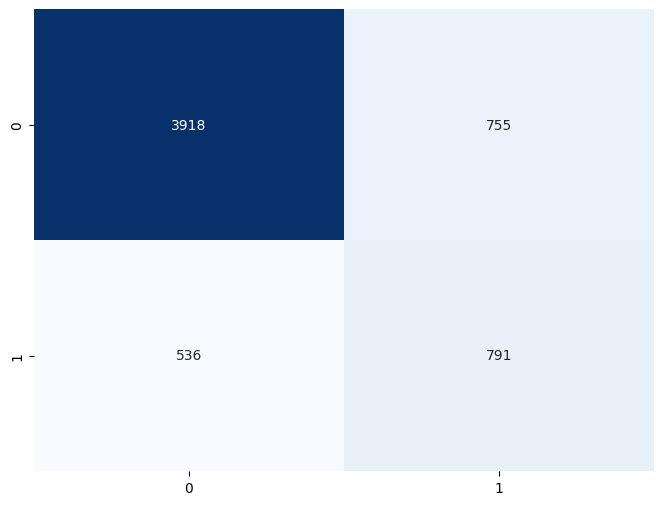

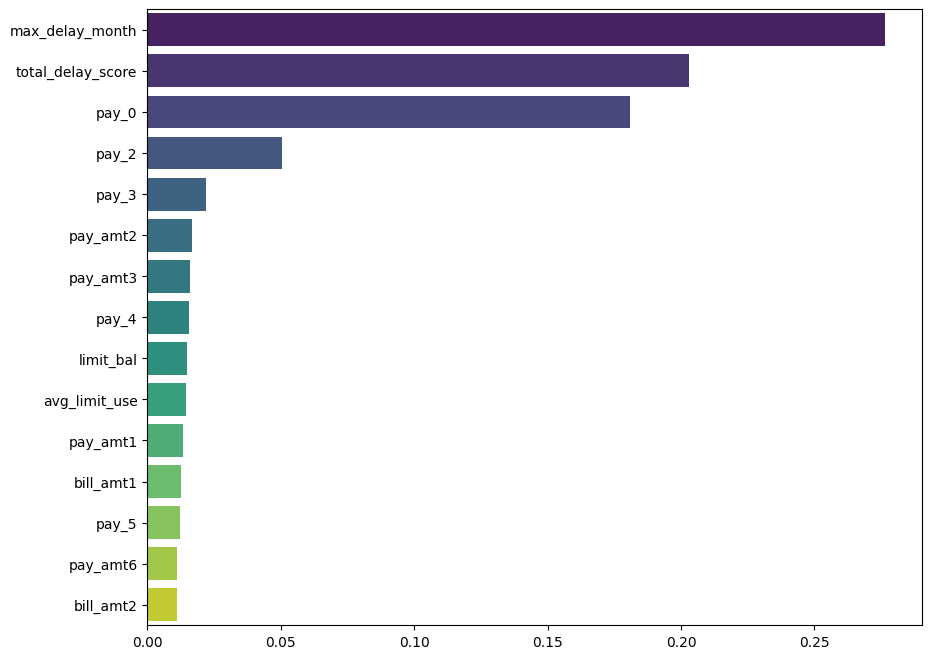

In [7]:
y_pred_optimized = (y_prob >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_optimized))
print(roc_auc_score(y_test, y_prob))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

feature_imp = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='viridis')
plt.show()

In [8]:
joblib.dump(best_model, 'final_model.pkl')
joblib.dump(X.columns.tolist(), 'features.pkl')

['features.pkl']

# 4. Final Model Değerlendirmesi ve Sonuçlar

Bu bölümde, geliştirilen **XGBoost** modelinin final performansı, özellik önem düzeyleri ve finansal risk analizi sonuçları değerlendirilmiştir.

## 4.1. Model Performans Özeti
Model, dengesiz veri seti üzerinde `RandomizedSearchCV` ile optimize edilmiş ve `Threshold Optimization` uygulanmıştır.

* **ROC AUC Skoru:** `0.7821` 
* **Accuracy (Doğruluk):** `0.78`
* **Recall (Sınıf 1 - Riskli Müşteri):** `0.60`
* **Precision (Sınıf 1):** `0.51`

---

## 4.2. Confusion Matrix Analizi (İş Kararları)
Modelin banka üzerindeki finansal etkisi aşağıdaki matris üzerinden yorumlanmıştır:

| Durum | Tahmin (Risk Yok - 0) | Tahmin (Riskli - 1) | Yorum (Business Impact) |
| :--- | :---: | :---: | :--- |
| **Gerçek (Risk Yok)** | **3918 (TN)** | 755 (FP) | 755 güvenilir müşteriye kredi verilmemiştir (Fırsat maliyeti), ancak 3918 doğru müşteri onaylanmıştır. |
| **Gerçek (Riskli)** | 536 (FN) | **791 (TP)** | **Kritik Başarı:** 791 batık kredi önceden tespit edilmiş ve bankanın zarar etmesi engellenmiştir. |

> **Analiz:** Modelimiz, finansal risk yönetiminde en kritik metrik olan "Riskli müşteriyi kaçırmama" (**Recall**) üzerine odaklanmıştır. **791** potansiyel batık kredinin tespiti, banka için ciddi bir sermaye koruması sağlar.

---

## 4.3. Özellik Önem Düzeyleri (Feature Importance)
Modelin karar verirken en çok hangi verilere odaklandığı incelendiğinde, **Feature Engineering** aşamasında ürettiğimiz yeni değişkenlerin zirvede olduğu görülmektedir.

1.  **`max_delay_month` (En Kritik Özellik):** Müşterinin geçmişteki en uzun gecikme süresi, borcunu ödeyip ödemeyeceğini belirleyen en temel faktör olmuştur.
2.  **`total_delay_score`:** Toplam gecikme yoğunluğu ikinci sırada gelmektedir.
3.  **`pay_0` - `pay_2`:** Yakın dönem ödeme performansları model için hala güçlü sinyallerdir.

** Sonuç:** Sadece ham veriler (örneğin fatura tutarı `bill_amt`) model için daha az önem taşırken, müşterinin **ödeme alışkanlıklarını** özetleyen türetilmiş özellikler model başarısını doğrudan artırmıştır.